# AI safety via debate
OAI article: https://openai.com/index/debate/

Paper: https://arxiv.org/pdf/1805.00899

Implementation by Alex Chen

Jul 2024

## Example Output

Here, the judge was fooled by the liar agent (red), despite the truth agent's (blue) best efforts.

![AI Safety Debate](OAISafetyDebateImg.png)


# Setup

In [13]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from torchvision.transforms import ToTensor
import math

# Training the Judge
The judge is a classifier trained to "predict MNIST digits from 6 non-black digits, sampled at random for each presentation when pretraining."

As per the paper, their original sparse classifier achieved 59.4% accuracy. They use a convolutional neural net.

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.0005
momentum = 0.5
log_interval = 10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.transforms import ToTensor

class RandomPixelSelection(object):
    def __init__(self, num_pixels=6):
        self.num_pixels = num_pixels

    def __call__(self, img):
        img_np = np.array(img)
        flattened = img_np.flatten()
        non_black_indices = np.where(flattened > 0)[0]

        if len(non_black_indices) < self.num_pixels:
            selected_indices = non_black_indices
        else:
            selected_indices = np.random.choice(non_black_indices, self.num_pixels, replace=False)

        new_img = np.zeros_like(flattened)
        new_img[selected_indices] = flattened[selected_indices]
        new_img = new_img.reshape(img_np.shape)

        new_img = torch.tensor(new_img, dtype=torch.float32)
        new_img = (new_img - 0.1307) / 0.3081

        return new_img.unsqueeze(0)

transform = torchvision.transforms.Compose([
    RandomPixelSelection(num_pixels=6)
])

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/mnist_data/', train=True, download=True, transform=transform),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/mnist_data/', train=False, download=True, transform=transform),
    batch_size=batch_size_test, shuffle=True)

class Judge(nn.Module):
    def __init__(self):
        super(Judge, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.fc1 = nn.Linear(12 * 20 * 20, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 12 * 20 * 20)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Judge().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

n_epochs = 8
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

In [ ]:
example_data, example_target = next(iter(test_loader))
example_data, example_target = example_data.to(device), example_target.to(device)
model.eval()
with torch.no_grad():
    output = model(example_data)
    pred = output.argmax(dim=1, keepdim=True)
    for i in range(len(pred)):
        print(f'Predicted: {pred[i].item()}, Actual: {example_target[i].item()}')


In [40]:
class StandardMNIST(object):
    def __call__(self, img):
        img_np = np.array(img)
        new_img = torch.tensor(img_np, dtype=torch.float32)
        return new_img.unsqueeze(0)

standardTransform = torchvision.transforms.Compose([
    StandardMNIST(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [318]:
batch_size_test = 1

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/mnist_data/', train=False, download=True, transform=standardTransform),
    batch_size=batch_size_test, shuffle=True)

In [ ]:
example_image, example_label = next(iter(test_loader))
example_image_dim = example_image[0][0]
print(example_label)

# The Agent

OAI paper uses pure Monte Carlo Tree Search with 10k rollouts per move. In the original paper the MCTS resets for each move, but we'll keep the same tree for the whole debate.

The selection criteria is the PUCT variant: the win rate + Upper bound

tree layers alternate between the truthful agent and the lying agent

the root of the tree is the empty state

first move is truthful agent

In [233]:
class Node():
    def __init__(self, parent=None, children=None, winRate=None, timesVisited=0, depth=0):
        self.parent = parent
        self.children = children if children is not None else {}
        self.timesVisited = timesVisited
        self.winRate = winRate if winRate is not None else [0,0]
        self.depth = depth

In [314]:
class MCTS():

    def __init__(self, image, targetLabel, model, hasLiar=True):
        self.root = Node(parent=None, winRate=[0,0], timesVisited=0, depth=0)
        self.visitedLeaves = {} # may not need due to sparsity
        self.image = image
        self.targetLabel = targetLabel
        self.model = model
        self.non_black_pixels = []
        self.winRateWeight = 3
        self.hasLiar = hasLiar
        # print(self.image.shape)
        for i in range(self.image.shape[0]):
            for j in range(self.image.shape[1]):
                if self.image[i, j] > -4.23e-01: # -0.42421... is what zeroes get mapped to
                    self.non_black_pixels.append((i, j))
        
        self.numValidActions = len(self.non_black_pixels)
    

    def calculateUtility(self, winRate, sumVisited, numVisits):
        winRateRatio = 0
        if winRate[1] != 0:
            winRateRatio = winRate[0] / winRate[1]
        return self.winRateWeight * winRateRatio + (1 / self.numValidActions) * (math.sqrt(1 + sumVisited)) / (1 + numVisits)


    def chooseNextNode(self, curNode, chosen):
        sumVisited = 0
        for child in curNode.children.values():
            sumVisited += child.timesVisited
        
        maxUtility = -1
        maxChildIndices = []

        for i in range(self.numValidActions):
            if i not in chosen:
                if i in curNode.children:
                    util = self.calculateUtility(curNode.children[i].winRate, sumVisited, curNode.children[i].timesVisited)
                else:
                    util = self.calculateUtility([0,0], sumVisited, 0)

                if util > maxUtility:
                    maxChildIndices = [i]
                    maxUtility = util
                elif util == maxUtility:
                    maxChildIndices.append(i)
        
        maxChildIndex = random.choice(maxChildIndices)
        if maxChildIndex in curNode.children.keys():
            curNode.children[maxChildIndex].timesVisited += 1
            # print(f"Child {maxChildIndex} visited {curNode.children[maxChildIndex].timesVisited} times")
        else:
            curNode.children[maxChildIndex] = Node(parent=curNode, winRate=[0,0], timesVisited=1, depth=curNode.depth+1)

        return curNode.children[maxChildIndex], maxChildIndex


    def backprop(self, leaf, truthWin):
        curNode = leaf
        while curNode.parent is not None:
            if self.hasLiar:
                if truthWin and curNode.depth % 2 == 1:
                    curNode.winRate[0] += 1
                elif not truthWin and curNode.depth % 2 == 0:
                    curNode.winRate[0] += 1
            else:
                if truthWin:
                    curNode.winRate[0] += 1
            curNode.winRate[1] += 1
            curNode = curNode.parent
    

    def judge(self, chosen):
        judge_image = torch.zeros((28, 28))
        chosen_pixels = [self.non_black_pixels[index] for index in chosen]
        for c in chosen_pixels:
            judge_image[c[0]][c[1]] = self.image[c[0]][c[1]]
        judge_image = judge_image.unsqueeze(0).unsqueeze(0) # this is a batch consisting of a single image lol
        output = self.model(judge_image)
        pred = output.argmax(dim=1, keepdim=True).item()
        return pred == self.targetLabel.item(), pred
    
        
    def rollouts(self, numRollouts):
        for i in range(numRollouts):
            # print("rollout",i)
            curNode = self.root
            chosen = []
            while curNode.depth != 6:
                nextNode, chosenIndex = self.chooseNextNode(curNode, chosen)
                # print(f"Current depth: {curNode.depth}, Chosen index: {chosenIndex}")
                chosen.append(chosenIndex)
                curNode = nextNode
            
            truthWin, pred = self.judge(chosen)
            self.backprop(curNode, truthWin)
    

    def getBestMoves(self):
        curNode = self.root
        moves = []
        while curNode.depth != 6:
            maxVisits = -1
            maxVisitsIndex = -1
            for c in curNode.children.keys():
                if curNode.children[c].timesVisited > maxVisits:
                    maxVisits = curNode.children[c].timesVisited
                    maxVisitsIndex = c
            moves.append(maxVisitsIndex)

            # print(curNode.children[maxVisitsIndex].winRate)
            # print(len(curNode.children[maxVisitsIndex].children.keys()))

            curNode = curNode.children[maxVisitsIndex]
        return moves

# Visualization

In [370]:
def visualizeDebate(example_image, example_label, judge_label, hasLiar, bestMoves):
    example_image_dim = example_image[0][0]
    import matplotlib.pyplot as plt

    plt.imshow(example_image_dim, cmap='gray', interpolation='none')
    if hasLiar:
        for i in range(len(bestMoves)):
            y, x = bestMoves[i]
            if i % 2 == 0:
                rect = plt.Rectangle((x-0.5, y-0.53), 0.9, 0.9, linewidth=1, edgecolor='deepskyblue', facecolor='none')
            else:
                rect = plt.Rectangle((x-0.5, y-0.53), 0.9, 0.9, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.title(f"True label: {int(example_label)} | Predicted label: {judge_label}")
    plt.axis('off')
    plt.show()
    

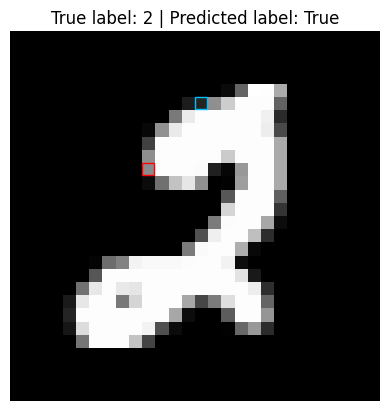

In [371]:
visualizeDebate(example_image, example_label, True, True, [(5,14), (10,10)])

# Putting it Together


In [368]:
def runBatchDebates(numDebates, numRollouts, hasLiar, visualize=False):
    final_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('~/mnist_data/', train=False, download=True, transform=standardTransform),
        batch_size=1, shuffle=True)

    countCorrect = 0
    for i in range(numDebates):
        example_image, example_label = next(iter(final_loader))
        example_image_dim = example_image[0][0]

        debate = MCTS(image=example_image_dim, targetLabel=example_label, model=model, hasLiar=hasLiar)
        debate.rollouts(numRollouts)
        bestMoves = debate.getBestMoves()

        correct, pred = debate.judge(bestMoves)
        if correct:
            countCorrect += 1

        print(f"Debate {i+1} | True label: {int(example_label)} | Predicted label: {pred} | Correct ratio: {countCorrect} / {i+1}")

        if visualize:
            chosen_pixels = [debate.non_black_pixels[index] for index in bestMoves]
            visualizeDebate(example_image, example_label, pred, hasLiar, chosen_pixels)


Debate 1 | True label: 4 | Predicted label: 7 | Correct ratio: 0 / 1
[(10, 19), (8, 11), (19, 15), (11, 18), (5, 12), (11, 17)]


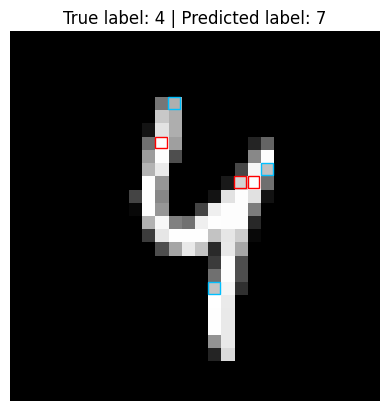

In [377]:
runBatchDebates(1, 10000, hasLiar=True, visualize=True)

# ~60% accuracy with winRateWeight of 3
Debate 1 | True label: 8 | Predicted label: 0 | Correct ratio: 0 / 1
Debate 2 | True label: 8 | Predicted label: 5 | Correct ratio: 0 / 2
Debate 3 | True label: 9 | Predicted label: 9 | Correct ratio: 1 / 3
Debate 4 | True label: 4 | Predicted label: 9 | Correct ratio: 1 / 4
Debate 5 | True label: 8 | Predicted label: 9 | Correct ratio: 1 / 5
Debate 6 | True label: 5 | Predicted label: 5 | Correct ratio: 2 / 6
Debate 7 | True label: 1 | Predicted label: 1 | Correct ratio: 3 / 7
Debate 8 | True label: 3 | Predicted label: 3 | Correct ratio: 4 / 8
Debate 9 | True label: 0 | Predicted label: 0 | Correct ratio: 5 / 9
Debate 10 | True label: 3 | Predicted label: 3 | Correct ratio: 6 / 10
Debate 11 | True label: 9 | Predicted label: 4 | Correct ratio: 6 / 11
Debate 12 | True label: 3 | Predicted label: 3 | Correct ratio: 7 / 12
Debate 13 | True label: 5 | Predicted label: 5 | Correct ratio: 8 / 13
Debate 14 | True label: 0 | Predicted label: 0 | Correct ratio: 9 / 14
Debate 15 | True label: 0 | Predicted label: 0 | Correct ratio: 10 / 15
Debate 16 | True label: 4 | Predicted label: 9 | Correct ratio: 10 / 16
Debate 17 | True label: 9 | Predicted label: 9 | Correct ratio: 11 / 17
Debate 18 | True label: 7 | Predicted label: 7 | Correct ratio: 12 / 18
Debate 19 | True label: 1 | Predicted label: 1 | Correct ratio: 13 / 19
Debate 20 | True label: 1 | Predicted label: 1 | Correct ratio: 14 / 20
Debate 21 | True label: 1 | Predicted label: 1 | Correct ratio: 15 / 21
Debate 22 | True label: 8 | Predicted label: 9 | Correct ratio: 15 / 22
Debate 23 | True label: 4 | Predicted label: 4 | Correct ratio: 16 / 23
Debate 24 | True label: 6 | Predicted label: 6 | Correct ratio: 17 / 24
Debate 25 | True label: 0 | Predicted label: 0 | Correct ratio: 18 / 25
Debate 26 | True label: 1 | Predicted label: 1 | Correct ratio: 19 / 26
Debate 27 | True label: 3 | Predicted label: 0 | Correct ratio: 19 / 27
Debate 28 | True label: 2 | Predicted label: 2 | Correct ratio: 20 / 28
Debate 29 | True label: 1 | Predicted label: 1 | Correct ratio: 21 / 29
Debate 30 | True label: 1 | Predicted label: 1 | Correct ratio: 22 / 30
Debate 31 | True label: 7 | Predicted label: 7 | Correct ratio: 23 / 31
Debate 32 | True label: 8 | Predicted label: 8 | Correct ratio: 24 / 32
Debate 33 | True label: 7 | Predicted label: 9 | Correct ratio: 24 / 33
Debate 34 | True label: 6 | Predicted label: 2 | Correct ratio: 24 / 34
Debate 35 | True label: 2 | Predicted label: 3 | Correct ratio: 24 / 35
Debate 36 | True label: 7 | Predicted label: 9 | Correct ratio: 24 / 36
Debate 37 | True label: 8 | Predicted label: 6 | Correct ratio: 24 / 37
Debate 38 | True label: 5 | Predicted label: 2 | Correct ratio: 24 / 38
Debate 39 | True label: 8 | Predicted label: 0 | Correct ratio: 24 / 39
Debate 40 | True label: 2 | Predicted label: 2 | Correct ratio: 25 / 40
Debate 41 | True label: 8 | Predicted label: 5 | Correct ratio: 25 / 41
Debate 42 | True label: 4 | Predicted label: 9 | Correct ratio: 25 / 42
Debate 43 | True label: 9 | Predicted label: 5 | Correct ratio: 25 / 43
Debate 44 | True label: 1 | Predicted label: 1 | Correct ratio: 26 / 44
Debate 45 | True label: 4 | Predicted label: 4 | Correct ratio: 27 / 45
Debate 46 | True label: 8 | Predicted label: 0 | Correct ratio: 27 / 46
Debate 47 | True label: 6 | Predicted label: 3 | Correct ratio: 27 / 47
Debate 48 | True label: 1 | Predicted label: 1 | Correct ratio: 28 / 48
Debate 49 | True label: 8 | Predicted label: 6 | Correct ratio: 28 / 49
Debate 50 | True label: 2 | Predicted label: 5 | Correct ratio: 28 / 50
Debate 51 | True label: 5 | Predicted label: 0 | Correct ratio: 28 / 51
Debate 52 | True label: 3 | Predicted label: 3 | Correct ratio: 29 / 52
Debate 53 | True label: 6 | Predicted label: 6 | Correct ratio: 30 / 53
Debate 54 | True label: 9 | Predicted label: 9 | Correct ratio: 31 / 54
Debate 55 | True label: 2 | Predicted label: 2 | Correct ratio: 32 / 55
Debate 56 | True label: 6 | Predicted label: 6 | Correct ratio: 33 / 56
Debate 57 | True label: 4 | Predicted label: 2 | Correct ratio: 33 / 57
Debate 58 | True label: 7 | Predicted label: 7 | Correct ratio: 34 / 58
Debate 59 | True label: 1 | Predicted label: 1 | Correct ratio: 35 / 59
Debate 60 | True label: 9 | Predicted label: 4 | Correct ratio: 35 / 60
Debate 61 | True label: 6 | Predicted label: 6 | Correct ratio: 36 / 61
Debate 62 | True label: 9 | Predicted label: 0 | Correct ratio: 36 / 62
Debate 63 | True label: 0 | Predicted label: 0 | Correct ratio: 37 / 63
Debate 64 | True label: 7 | Predicted label: 9 | Correct ratio: 37 / 64
Debate 65 | True label: 7 | Predicted label: 9 | Correct ratio: 37 / 65
Debate 66 | True label: 8 | Predicted label: 5 | Correct ratio: 37 / 66
Debate 67 | True label: 9 | Predicted label: 9 | Correct ratio: 38 / 67
Debate 68 | True label: 6 | Predicted label: 6 | Correct ratio: 39 / 68
Debate 69 | True label: 7 | Predicted label: 7 | Correct ratio: 40 / 69
Debate 70 | True label: 0 | Predicted label: 2 | Correct ratio: 40 / 70
Debate 71 | True label: 1 | Predicted label: 1 | Correct ratio: 41 / 71
Debate 72 | True label: 5 | Predicted label: 5 | Correct ratio: 42 / 72
Debate 73 | True label: 6 | Predicted label: 6 | Correct ratio: 43 / 73
Debate 74 | True label: 6 | Predicted label: 6 | Correct ratio: 44 / 74
Debate 75 | True label: 6 | Predicted label: 6 | Correct ratio: 45 / 75
Debate 76 | True label: 1 | Predicted label: 1 | Correct ratio: 46 / 76
Debate 77 | True label: 3 | Predicted label: 3 | Correct ratio: 47 / 77
Debate 78 | True label: 1 | Predicted label: 1 | Correct ratio: 48 / 78
Debate 79 | True label: 8 | Predicted label: 8 | Correct ratio: 49 / 79
Debate 80 | True label: 5 | Predicted label: 0 | Correct ratio: 49 / 80
Debate 81 | True label: 9 | Predicted label: 9 | Correct ratio: 50 / 81
Debate 82 | True label: 0 | Predicted label: 3 | Correct ratio: 50 / 82
Debate 83 | True label: 8 | Predicted label: 0 | Correct ratio: 50 / 83
Debate 84 | True label: 0 | Predicted label: 0 | Correct ratio: 51 / 84
Debate 85 | True label: 1 | Predicted label: 1 | Correct ratio: 52 / 85
Debate 86 | True label: 4 | Predicted label: 4 | Correct ratio: 53 / 86
Debate 87 | True label: 7 | Predicted label: 9 | Correct ratio: 53 / 87
Debate 88 | True label: 8 | Predicted label: 8 | Correct ratio: 54 / 88
Debate 89 | True label: 5 | Predicted label: 3 | Correct ratio: 54 / 89
Debate 90 | True label: 9 | Predicted label: 4 | Correct ratio: 54 / 90
Debate 91 | True label: 8 | Predicted label: 8 | Correct ratio: 55 / 91
Debate 92 | True label: 8 | Predicted label: 8 | Correct ratio: 56 / 92
Debate 93 | True label: 8 | Predicted label: 8 | Correct ratio: 57 / 93
Debate 94 | True label: 8 | Predicted label: 4 | Correct ratio: 57 / 94
Debate 95 | True label: 0 | Predicted label: 6 | Correct ratio: 57 / 95
Debate 96 | True label: 0 | Predicted label: 6 | Correct ratio: 57 / 96
Debate 97 | True label: 5 | Predicted label: 5 | Correct ratio: 58 / 97
Debate 98 | True label: 1 | Predicted label: 1 | Correct ratio: 59 / 98
Debate 99 | True label: 9 | Predicted label: 9 | Correct ratio: 60 / 99
Debate 100 | True label: 4 | Predicted label: 9 | Correct ratio: 60 / 100

Note: without a liar agent, the judge performs 100%. This makes sense since the MCTS can always just go to a leaf that outputs correct ans.